# Coloring gray images
Here, we use the C-implementation of the collision-based dynamics to find the optimal map between a gray and colored picture of Robert De Niro. Then, we train a Neural Network to learn the map using the optimally paired data points. Ultimately, we test the trained network to make a gray image of Einstein colorful.

First, we import necessary libraries and read the images.

In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src/collisional_ot/cython'))
sys.path.append(src_path)
from collision_wrapper import collOT_c

rng = np.random.seed(0)

ModuleNotFoundError: No module named 'collision_wrapper'

(-0.5, 99.5, 124.5, -0.5)

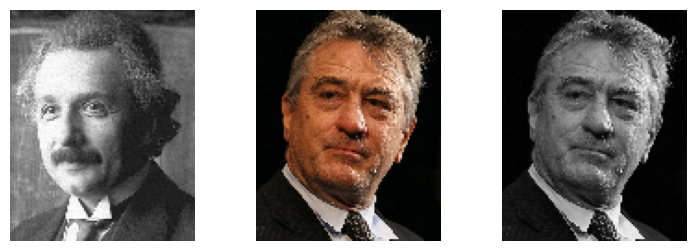

In [20]:
image_path = 'Einstein.jpg'
image1 = np.array( Image.open(image_path).convert('L') )
image1 = np.stack((image1,)*3, axis=-1)

image_path = 'RobertDeNiro.jpg'
image2 = np.array(Image.open(image_path))
image2_bw = np.array( Image.open(image_path).convert('L') )
image2_bw = np.stack((image2_bw,)*3, axis=-1)

im1 = image1.copy()
im1 = im1[50:550,100:500,:][::4,::4]

im2 = image2.copy()
im2 = im2[::5,::5,:][23:-23,2:-3][::2,::2]

im2_bw = image2_bw.copy()
im2_bw = im2_bw[::5,::5,:][23:-23,2:-3][::2,::2]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(im1)
axes[0].axis('off')
axes[1].imshow(im2)
axes[1].axis('off')
axes[2].imshow(im2_bw)
axes[2].axis('off')

Reshape images to be of the size (number of pixels, number of colors) and normalized with the range (0,1).

In [19]:
X0 = im2_bw.copy()/256.0
Y0 = im2.copy()/256.0
X = X0.copy()
X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])

Y = Y0.copy()
Y = Y.reshape(Y.shape[0]*Y.shape[1],Y.shape[2])

print(X.shape)
print(Y.shape)

(12500, 3)
(12500, 3)


## OT using collision-based dynamics
Now, we find the optimal map between gray and colored images using the C-implementation of the collisional OT.

Text(0, 0.5, '$\\mathbb{E}[||X_t^{(1)}-X_t^{(2)}||_2^2]$')

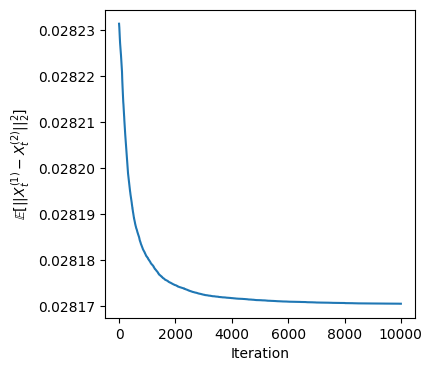

In [23]:
Xt = np.concatenate([X[None,],Y[None,]],axis=0)
Xt, dists0, nt = collOT_c(Xt, MinIter=10000, MaxIter=10000, tol = 1e-9, avg_window=20, Track=1)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(dists0)
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\mathbb{E}[||X_t^{(1)}-X_t^{(2)}||_2^2]$")

## Training a Neural Newtork
Next, we train a simple Neural Network to learn the map between gray and colored image. Here, we use PyTorch.

In [24]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss

In [28]:
from torch import nn, optim

X = torch.tensor(Xt[0,:], dtype=torch.float32)
Y = torch.tensor(Xt[1,:], dtype=torch.float32)

# Create a simple model and optimizer
model_ocd = Model(input_dim=3)
optimizer = optim.Adam(model_ocd.parameters(), lr=5e-4)

# Training loop
n_epochs = 5000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_ocd.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model_ocd.eval()

Epoch 1000, Loss: 0.003943883813917637
Epoch 2000, Loss: 0.00387613195925951
Epoch 3000, Loss: 0.003869155654683709
Epoch 4000, Loss: 0.003889108542352915
Epoch 5000, Loss: 0.003867401508614421


Model(
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=3, bias=True)
  )
)

Text(0, 0.5, 'Loss')

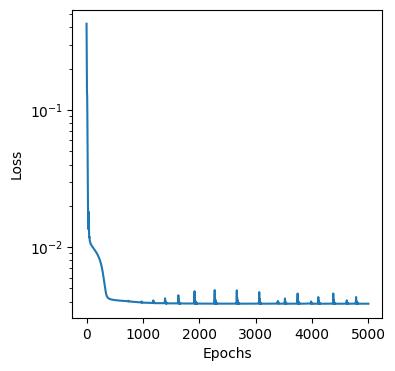

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(losses)
ax.set_yscale("log")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"Loss")

Now we can test the trained network by plugging in another gray image as input and check the output image.

(-0.5, 99.5, 124.5, -0.5)

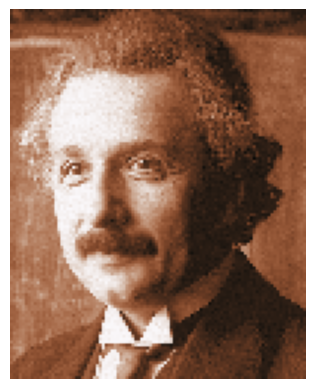

In [31]:
Xtest = im1.reshape(im1.shape[0]*im1.shape[1],im1.shape[2]).copy()/256.0
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = model_ocd.forward(Xtest)
Ytest = Ytest.detach().numpy()
Ytest = Ytest.reshape(im1.shape[0],im1.shape[1],im1.shape[2])

plt.imshow(Ytest)
plt.axis('off')